In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from itertools import chain
from ddeint import ddeint

sns.set_theme(style="darkgrid")

In [41]:
def FH_N(t, y, a=5, tau_n=60, I=-4.2):
    v, n = y
    dvdt = v - (v**3) / 3 - n + I
    dndt = (a * v - n) / tau_n

    return np.array([dvdt, dndt])

## Diffusive Coupling Between Neurons

$$\text{neuron-coupled-term}_i = \sum_{j} g_{ij} (v_j - v_i)$$

In [42]:
def FHN_system(t:float, y:np.array, L:np.array, d1:float, d2:float, g_c:float = 0.25, u_syn:float = 0.8, a:float = 0.7, b:float = 0.8, c:float = 3):
    u = y[0::2]
    v = y[1::2]

    u_coupled_term = d1*L@u
    v_coupled_term = d2*L@v

    dudt = u - 1/3*np.power(u,3) + v + g_c * np.tanh(u - u_syn) + u_coupled_term
    dvdt = (a - b*v - u) / c + v_coupled_term

    dsystemdt = np.array( list(chain.from_iterable(zip(dudt, dvdt))) )

    return dsystemdt

In [43]:
def make_FHN_system(L: np.array, d1: float, d2: float, tau: float, 
                    g_c: float = 0.6, u_syn: float = 0.8, a: float = 0.7, 
                    b: float = 0.8, c: float = 3):
    def FHN_system(Y, t):
        y_now = Y(t)
        y_delay = Y(t - tau)

        u = y_now[0::2]
        v = y_now[1::2]

        u_delay = y_delay[0::2]  # Only delay u, not v

        u_coupled_term = d1 * L @ u
        v_coupled_term = d2 * L @ v

        dudt = u - (1/3) * np.power(u, 3) + v + g_c * np.tanh(u_delay - u_syn) + u_coupled_term
        dvdt = (a - b * v - u) / c + v_coupled_term

        dsystemdt = np.array(list(chain.from_iterable(zip(dudt, dvdt))))
        return dsystemdt

    return FHN_system


In [44]:
def initialize_delayed_fhn(d:float, g_c:float = 0.25, u_syn:float = 0.8, a:float = 0.7, b:float = 0.8, c:float = 3):
    def delayed_fhn(Y,t):
        y_now = Y(t)
        y_delay = Y(t-d)

        u,v = y_now
        u_delay,_ = y_delay

        dudt = u - 1/3*u**3 + v + g_c * np.tanh(u_delay - u_syn)
        dvdt = ( -u + a - b*v )/c

        return [dudt, dvdt]
    return delayed_fhn

In [ ]:
# Test Parameters
a = 0.7
b = 0.8
c = 3.0
tau = 100
g_c = 0.8
u_syn = 0.0

# Setting up time mesh
dt = 0.01
T = 300
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

# Initializing DDE function
delayed_fhn = initialize_delayed_fhn(u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c)

# Setting History Function
def history(t):
    return [0.1, 0]

# Solving DDE Numerically
soln = ddeint(func=delayed_fhn, g=history, tt=t_span )

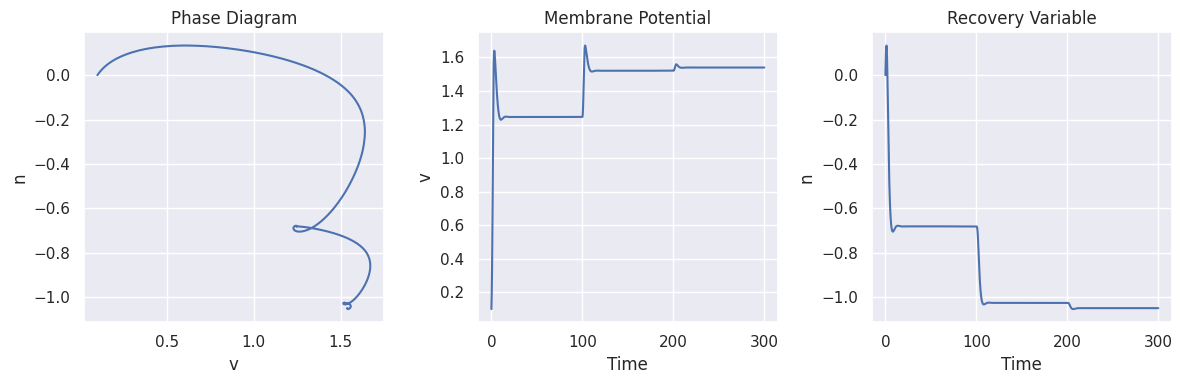

In [50]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(soln[:,0], soln[:,1])
plt.xlabel('v')
plt.ylabel('n')
plt.title('Phase Diagram')

plt.subplot(1, 3, 2)
plt.plot(t_span, soln[:,0])
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Membrane Potential')

plt.subplot(1, 3, 3)
plt.plot(t_span, soln[:,1])
plt.xlabel('Time')
plt.ylabel('n')
plt.title('Recovery Variable')

plt.tight_layout()
plt.show()

# References

[1] S. Gao, J. Shen, and X. Hu, “Dynamics of delayed and diffusive FitzHugh–Nagumo network,” Eur. Phys. J. Spec. Top., Apr. 2024, doi: 10.1140/epjs/s11734-024-01193-4.